In [1]:
#%matplotlib inline
%matplotlib widget

In [2]:
# initialization
from rayoptics.environment import *

from rayoptics.raytr import sampler

from rayoptics.mpl.analysisfigure import AnalysisFigure, Wavefront, RayFanPlot, RayGeoPSF
from matplotlib import gridspec
import matplotlib.colors as mcolors

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
# from IPython.display import display

In [3]:
def create_focus_dashboard(figs, ray_data_items, foc, dfoc_rng, shift_rng, on_axis_pt, continuous_update=True):
    defocus=widgets.FloatSlider(min=-dfoc_rng, max=+dfoc_rng, step=.01*dfoc_rng,
                                description='defocus', value=foc,
                                readout_format='.4f', continuous_update=continuous_update)
    x_shift=widgets.FloatSlider(min=-shift_rng, max=+shift_rng, step=.01*shift_rng,
                                description='x shift', value=on_axis_pt[0],
                                readout_format='.4f', continuous_update=continuous_update)
    y_shift=widgets.FloatSlider(min=-shift_rng, max=+shift_rng, step=.01*shift_rng,
                                description='y shift', value=on_axis_pt[1],
                                readout_format='.4f', continuous_update=continuous_update)

    def slider_update(change):
        dfoc_val = defocus.value
        dx = x_shift.value
        dy = y_shift.value

        # apply changes to fans and grids
        for ray_data in ray_data_items:
            ray_data.foc = dfoc_val
            ray_data.image_pt_2d = np.array([dx, dy])
            ray_data.update_data(build='update')

        # update and plot results
        for fig in figs:
            fig.clf()
            fig.plot()

    defocus.observe(slider_update, names='value')
    x_shift.observe(slider_update, names='value')
    y_shift.observe(slider_update, names='value')
    
    return defocus, x_shift, y_shift

In [4]:
root_pth = Path(rayoptics.__file__).resolve().parent

# Create a new model

In [5]:
opm = OpticalModel()
sm = opm.seq_model
osp = opm.optical_spec
pm = opm.parax_model

## Define first order aperture and field for system

In [6]:
pupil_diameter = 100.
pupil_radius = pupil_diameter/2
osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value=pupil_diameter)

# single field on-axis
osp.field_of_view = FieldSpec(osp, key=['object', 'angle'], flds=[0.0])

# wavelength for analysis: 550nm
osp.spectral_region = WvlSpec([(550.0, 1.0)], ref_wl=0)

### object at infinity, i.e. collimated input

In [7]:
sm.gaps[0].thi = 1e+11

In [8]:
#opm.add_mirror(lbl='M1', r=-500., t=-250.)
opm.add_mirror(lbl='M1', profile=Conic, r=-500., cc=-1., t=-250.)

In [9]:
opm.update_model()
fod = osp.parax_data.fod

# List first order data

In [10]:
fod.list_first_order_data()

efl                 250
ffl                -250
pp1                  -0
bfl                 250
ppk                   0
f/#                 2.5
m                     0
red              -4e+08
obj_dist          1e+11
obj_ang               1
enp_dist             -0
enp_radius           50
na obj            5e-10
n obj                 1
img_dist           -250
img_ht            4.364
exp_dist             -0
exp_radius           50
na img           0.1961
n img                -1
optical invariant       0.8728


In [11]:
fod.img_na

0.196116134666751

In [12]:
opd = 0.25*opm.nm_to_sys_units(osp.spectral_region.central_wvl)
dfoc = opd/(fod.img_na**2/(2*fod.n_img)); dfoc

-0.0071500000343749995

In [13]:
fod.img_na**2

0.03846153827662722

# Draw a lens picture

In [14]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_paraxial_layout=False).plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray', scale_type=Fit.All_Same).plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
wav_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='OPD', scale_type=Fit.All_Same).plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
fld, wvl, foc = osp.lookup_fld_wvl_focus(0)

In [18]:
opd = opm.nm_to_sys_units(wvl)
# one wave of defocus
dfoc = opd/(fod.img_na**2/(2*fod.n_img))
qwrt_dfoc = abs(0.25*dfoc)
# one wave of tilt
_, _, ref_sphere_radius = fld.ref_sphere
shft = ref_sphere_radius*opd/fod.exp_radius

In [19]:
ctr_ray = trace_base(opm, [0., 0.], fld, wvl)
img_offset = ctr_ray[0][-1][0]
on_axis_pt = np.array([img_offset[0], img_offset[1]])

num_rays=21
ray_grid = analyses.RayGrid(opm, f=fld, wl=wvl, image_pt_2d=on_axis_pt)

r2g = (sampler.create_generator, (sampler.R_2_quasi_random_generator, num_rays**2),
       dict(mapper=sampler.concentric_sample_disk))
ray_list = analyses.RayList(opm, pupil_gen=r2g, f=fld, wl=wvl, image_pt_2d=on_axis_pt)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

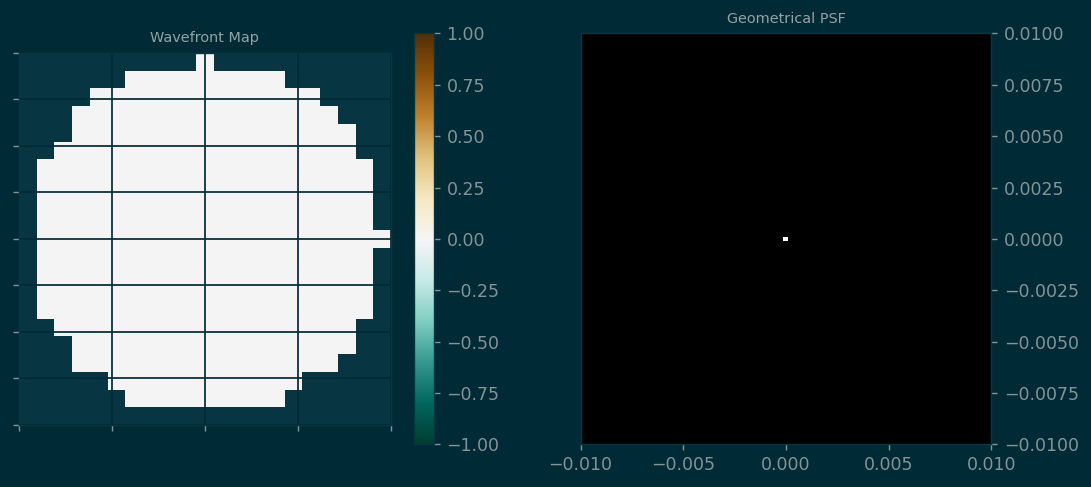

In [20]:
wfr = Wavefront(ray_grid, user_scale_value=1.0, do_contours=False,
                title='Wavefront Map', cmap="BrBG_r")

us = 0.01
scaler = mcolors.Normalize(vmin=0., vmax=80)
gPSF = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d', gamma=1./1.8,
                 title='Geometrical PSF', yaxis_ticks_position='right', #norm=scaler, vmax=80,
                 cmap='gray')

wvfig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_grid, ray_list], subplots=[wfr, gPSF],
                   grid=(1, 2), figsize=[9, 4], dpi=125, tight_layout=True, is_dark=True)

defocus, x_shift, y_shift = create_focus_dashboard([wvfig], [ray_grid, ray_list],
                                                   osp.defocus.focus_shift, abs(dfoc), shft, on_axis_pt)
wvfig.plot()

In [21]:
display(widgets.HBox([defocus, y_shift]))

In [22]:
wfr = Wavefront(ray_grid, user_scale_value=1.0, do_contours=False,
                title='Wavefront Map', cmap="BrBG_r")
wvfig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_grid],subplots=[wfr],
                   figsize=[6, 5], tight_layout=True, is_dark=True).plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …